here we pull the outputs saved by `run.py` and analyze them.

In [1]:
import os
import numpy as np
import yaml
import pickle
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

/lscratch/humna/ipykernel_559009/115119132.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### load in config

In [3]:
config_path = '../scripts/config.yml'
config = yaml.safe_load(open(config_path, 'r'))

outdir = config['outdir']
basepath = config['basepath']
tag_to_look_for = config['tag_to_look_for']

timepts = config['timepts']
time_points = np.arange(timepts[0], timepts[1], timepts[2])
del timepts

### lets first see whats sims there are

In [4]:
for cat in ['baseline', 'weather']:
    dbpath = f'{basepath}/{cat}'
    print([f for f in os.listdir(dbpath) if f.endswith(tag_to_look_for)])

['baseline_v4.3.1_10yrs.db']
['weather_cloudso18v4.3.1_10yrs.db', 'weather_cloudso10v4.3.1_10yrs.db', 'weather_cloudso2v4.3.1_10yrs.db', 'weather_cloudso30v4.3.1_10yrs.db', 'weather_cloudso12v4.3.1_10yrs.db', 'weather_cloudso6v4.3.1_10yrs.db', 'weather_cloudso35v4.3.1_10yrs.db', 'cloudso36v4.3.1_10yrs.db', 'weather_cloudso1v4.3.1_10yrs.db', 'weather_cloudso0v4.3.1_10yrs.db', 'weather_cloudso4v4.3.1_10yrs.db', 'weather_cloudso16v4.3.1_10yrs.db', 'weather_cloudso31v4.3.1_10yrs.db', 'weather_cloudso20v4.3.1_10yrs.db', 'weather_cloudso36v4.3.1_10yrs.db']


lets add some tags for helpful idenitification of the various sims

### read in the metrics data

In [5]:
fnovs_base = f'{outdir}/metrics/fnovs_vector_base.pickle'

out = pickle.load(open(fnovs_base, 'rb'))
fnovs_time_all, fnovs_time_per_filter = out['fnovs_time_all'], out['fnovs_time_per_filter']

## plot

In [6]:
baseline_tag = None
clouds_tag = {}
ints = []
for db in fnovs_time_all:
    if db.__contains__('baseline'):
        baseline_tag = db
    else:
        clouds_tag[db] = int(db.split('cloudso')[-1].split('v')[0])

clouds_tag = {k: v for k, v in sorted(clouds_tag.items(), key=lambda item: item[1], reverse=False)}

<Figure size 640x480 with 0 Axes>

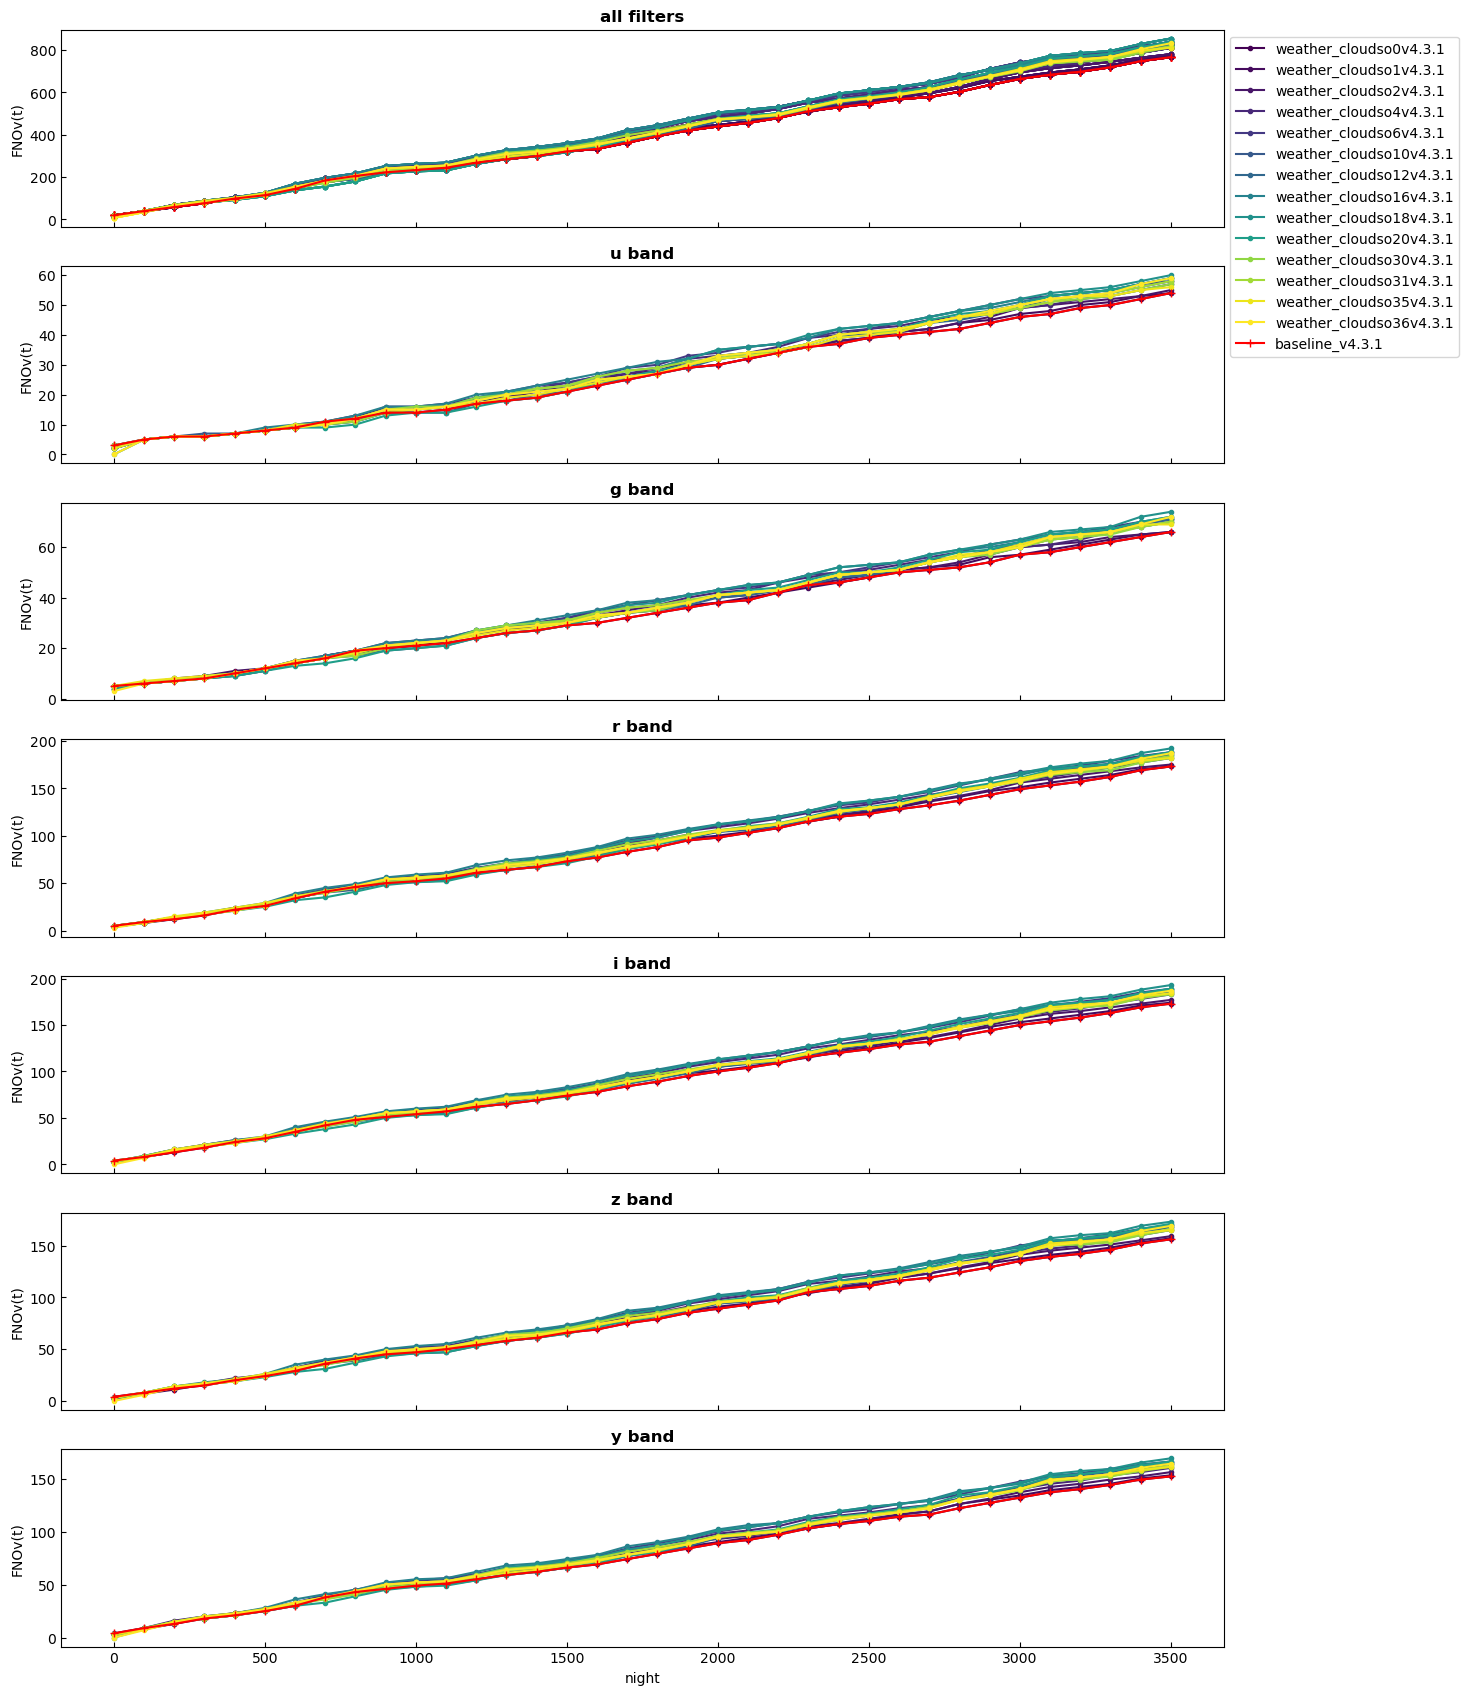

In [7]:
nrows, ncols = 7, 1

plt.clf()
fig, axes = plt.subplots(nrows, ncols)

for i, filt in enumerate(fnovs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys()) + [baseline_tag]):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            sym = '.'
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
        axes[0].plot(time_points[:-1], fnovs_time_all[db], sym+'-', label=db if i == 0 else None, color=color)
        axes[i+1].plot(time_points[:-1], fnovs_time_per_filter[filt][db], sym+'-', color=color)

        if j == 0:
            axes[0].set_title('all filters', fontweight='bold')
            axes[i+1].set_title(f'{filt} band', fontweight='bold')
            
for k in range(nrows):
    axes[k].tick_params(axis="both", direction="in")
    axes[k].set_ylabel('FNOv(t)')
for k in range(nrows-1):
    axes[k].set_xticklabels([])

axes[0].legend(bbox_to_anchor=(1,1))
axes[-1].set_xlabel('night')

fig.set_size_inches(15, nrows*3)
plt.show()

ok not the most helpful plot .. lets plot the differences from baseline.

<Figure size 640x480 with 0 Axes>

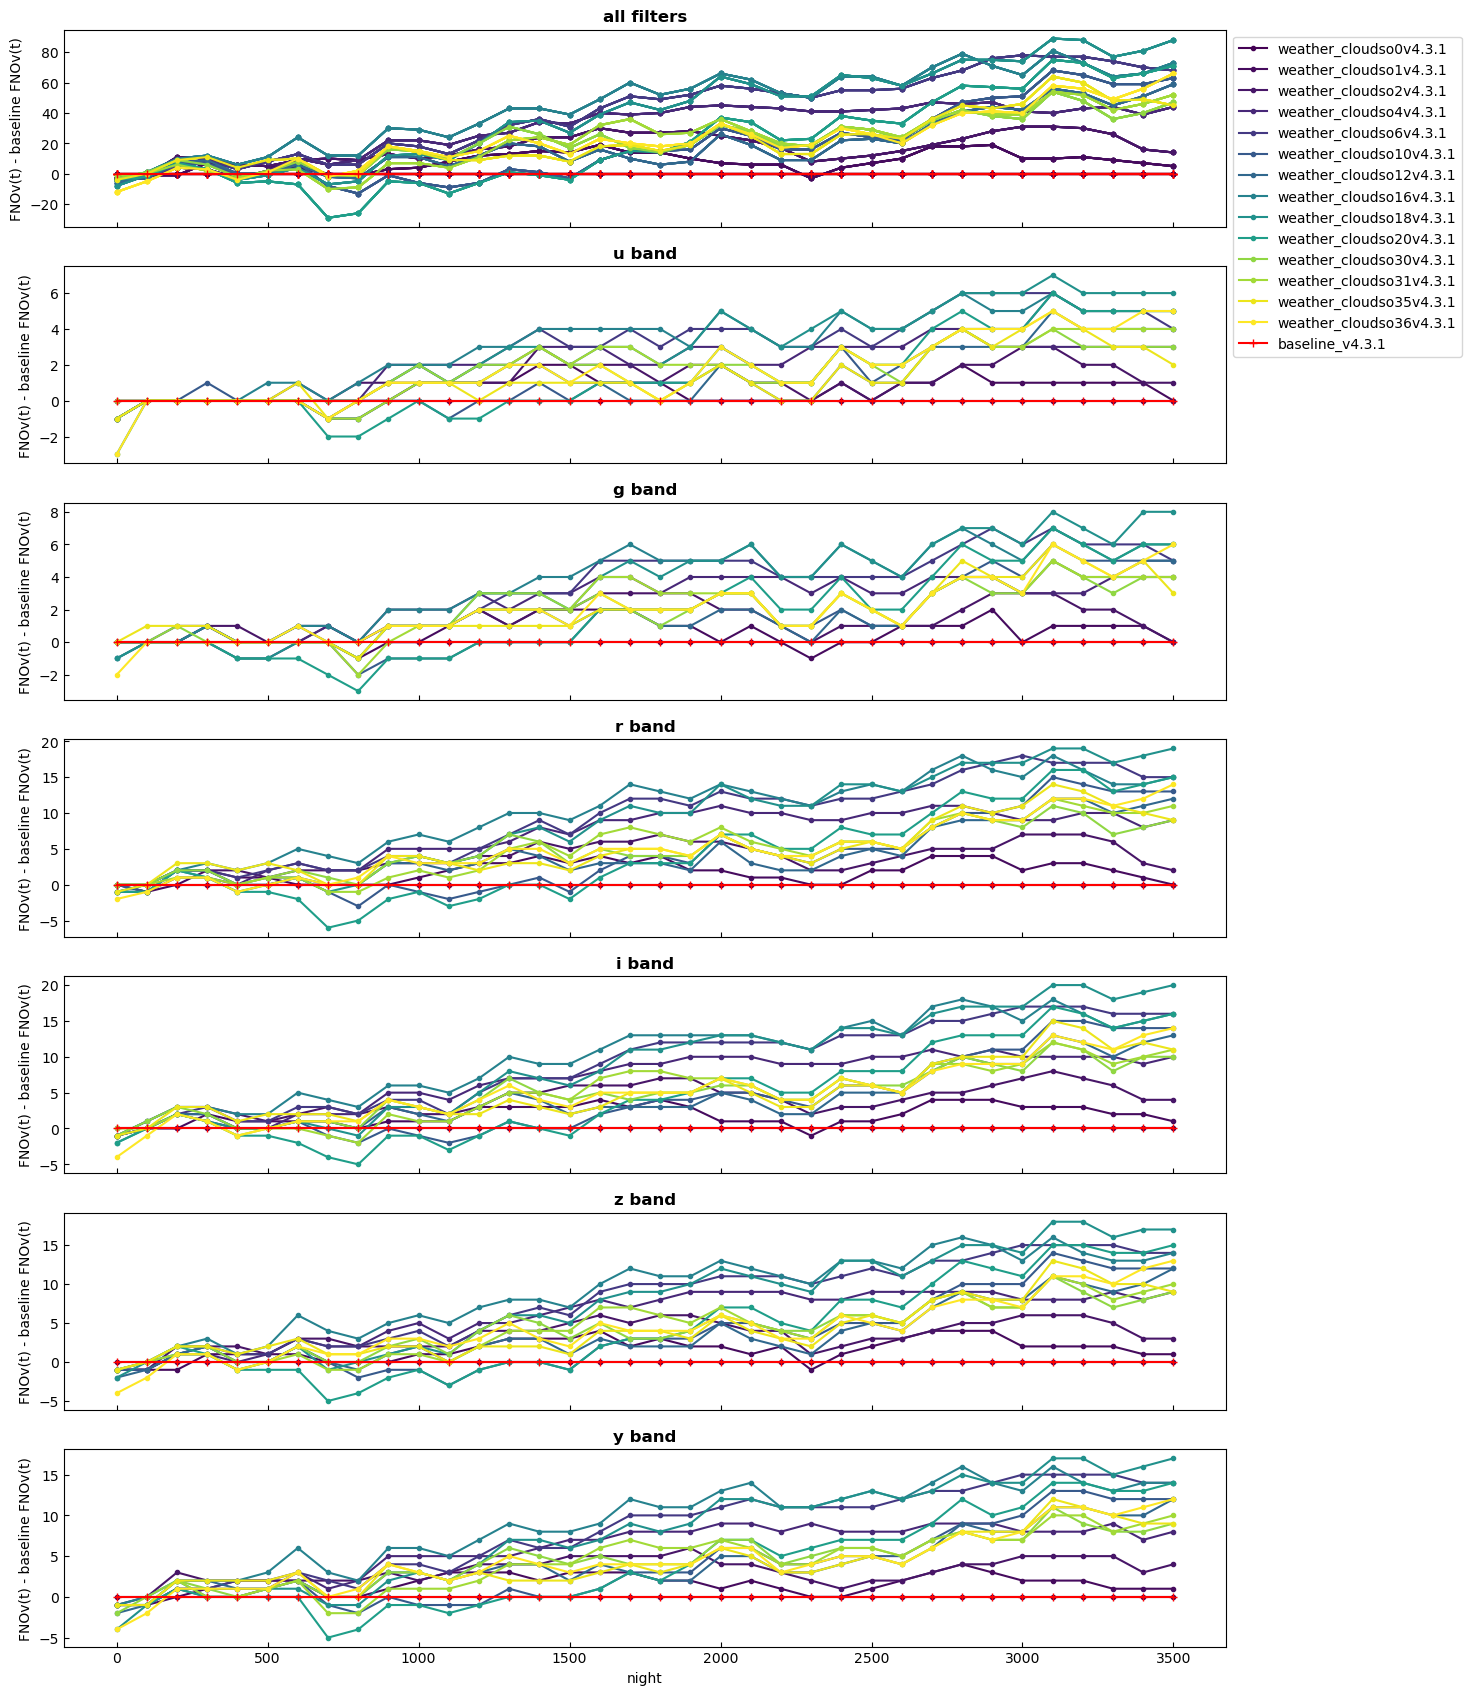

In [8]:
nrows, ncols = 7, 1

plt.clf()
fig, axes = plt.subplots(nrows, ncols)

for i, filt in enumerate(fnovs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys()) + [baseline_tag]):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
            sym = '.'
        
        axes[0].plot(time_points[:-1], fnovs_time_all[db] - fnovs_time_all[baseline_tag], sym+'-', label=db if i == 0 else None, color=color)
        axes[i+1].plot(time_points[:-1], fnovs_time_per_filter[filt][db] - fnovs_time_per_filter[filt][baseline_tag], sym+'-', color=color)

        if j == 0:
            axes[0].set_title('all filters', fontweight='bold')
            axes[i+1].set_title(f'{filt} band', fontweight='bold')
            
for k in range(nrows):
    axes[k].tick_params(axis="both", direction="in")
    axes[k].set_ylabel('FNOv(t) - baseline FNOv(t)')
for k in range(nrows-1):
    axes[k].set_xticklabels([])

axes[0].legend(bbox_to_anchor=(1,1))
axes[-1].set_xlabel('night')

fig.set_size_inches(15, nrows*3)
plt.show()

ok we see a modest variation. naviely one would think that cloud tag number increase would linearly correlate with the metric - but it doesnt. thats because the cloud tag number doesnt indicate the clouds are more/less but the years of cloud data thats being used (how exactly is something to document in this context).

## chimera sims

les add metric results from sims we've saved using the `--chimera` option in `run.py`.

In [9]:
chimera_fnovs_time_all, chimera_fnovs_time_per_filter = {}, {}

for outfile in [f for f in os.listdir(f'{outdir}/metrics') if f.startswith('fnovs_vector_chimera_cutoff')]:
    # read in
    chimera_metrics = f'{outdir}/metrics/{outfile}'

    cutoff = outfile.split('cutoff')[-1].split('.pickle')[0]
    
    out = pickle.load(open(chimera_metrics, 'rb'))
    chimera_fnovs_time_all[cutoff], chimera_fnovs_time_per_filter[cutoff] = out['chimera_fnovs_time_all'], out['chimera_fnovs_time_per_filter']

lets also find the night number at which things should change in our plots

In [10]:
import pandas as pd
import sqlite3
from astropy.time import Time
import astropy.units as u

conn = sqlite3.connect('/sdf/data/rubin/shared/fbs_sims/sims_longterm_tests//baseline/baseline_v4.3.1_10yrs.db')
query = f"select * from observations limit 1"
df = pd.read_sql(query, conn)
conn.close()

start = Time(df['observationStartMJD'].min(), format='mjd')

cutoff_night = {}
for cutoff in chimera_fnovs_time_all:
    cutoff_obj =  Time(cutoff, format='isot')
    
    cutoff_night[cutoff] = (cutoff_obj - start).to(u.day).value # is this correct? need to think if we should be rounding up/down
    print(f'## nights between start {start.isot[0:10]} and cutoff {cutoff}: {cutoff_night[cutoff] }')

## nights between start 2025-11-01 and cutoff 2026-03-01: 119.99841812172235
## nights between start 2025-11-01 and cutoff 2028-09-01: 1034.9984181217224


now lets plot

<Figure size 640x480 with 0 Axes>

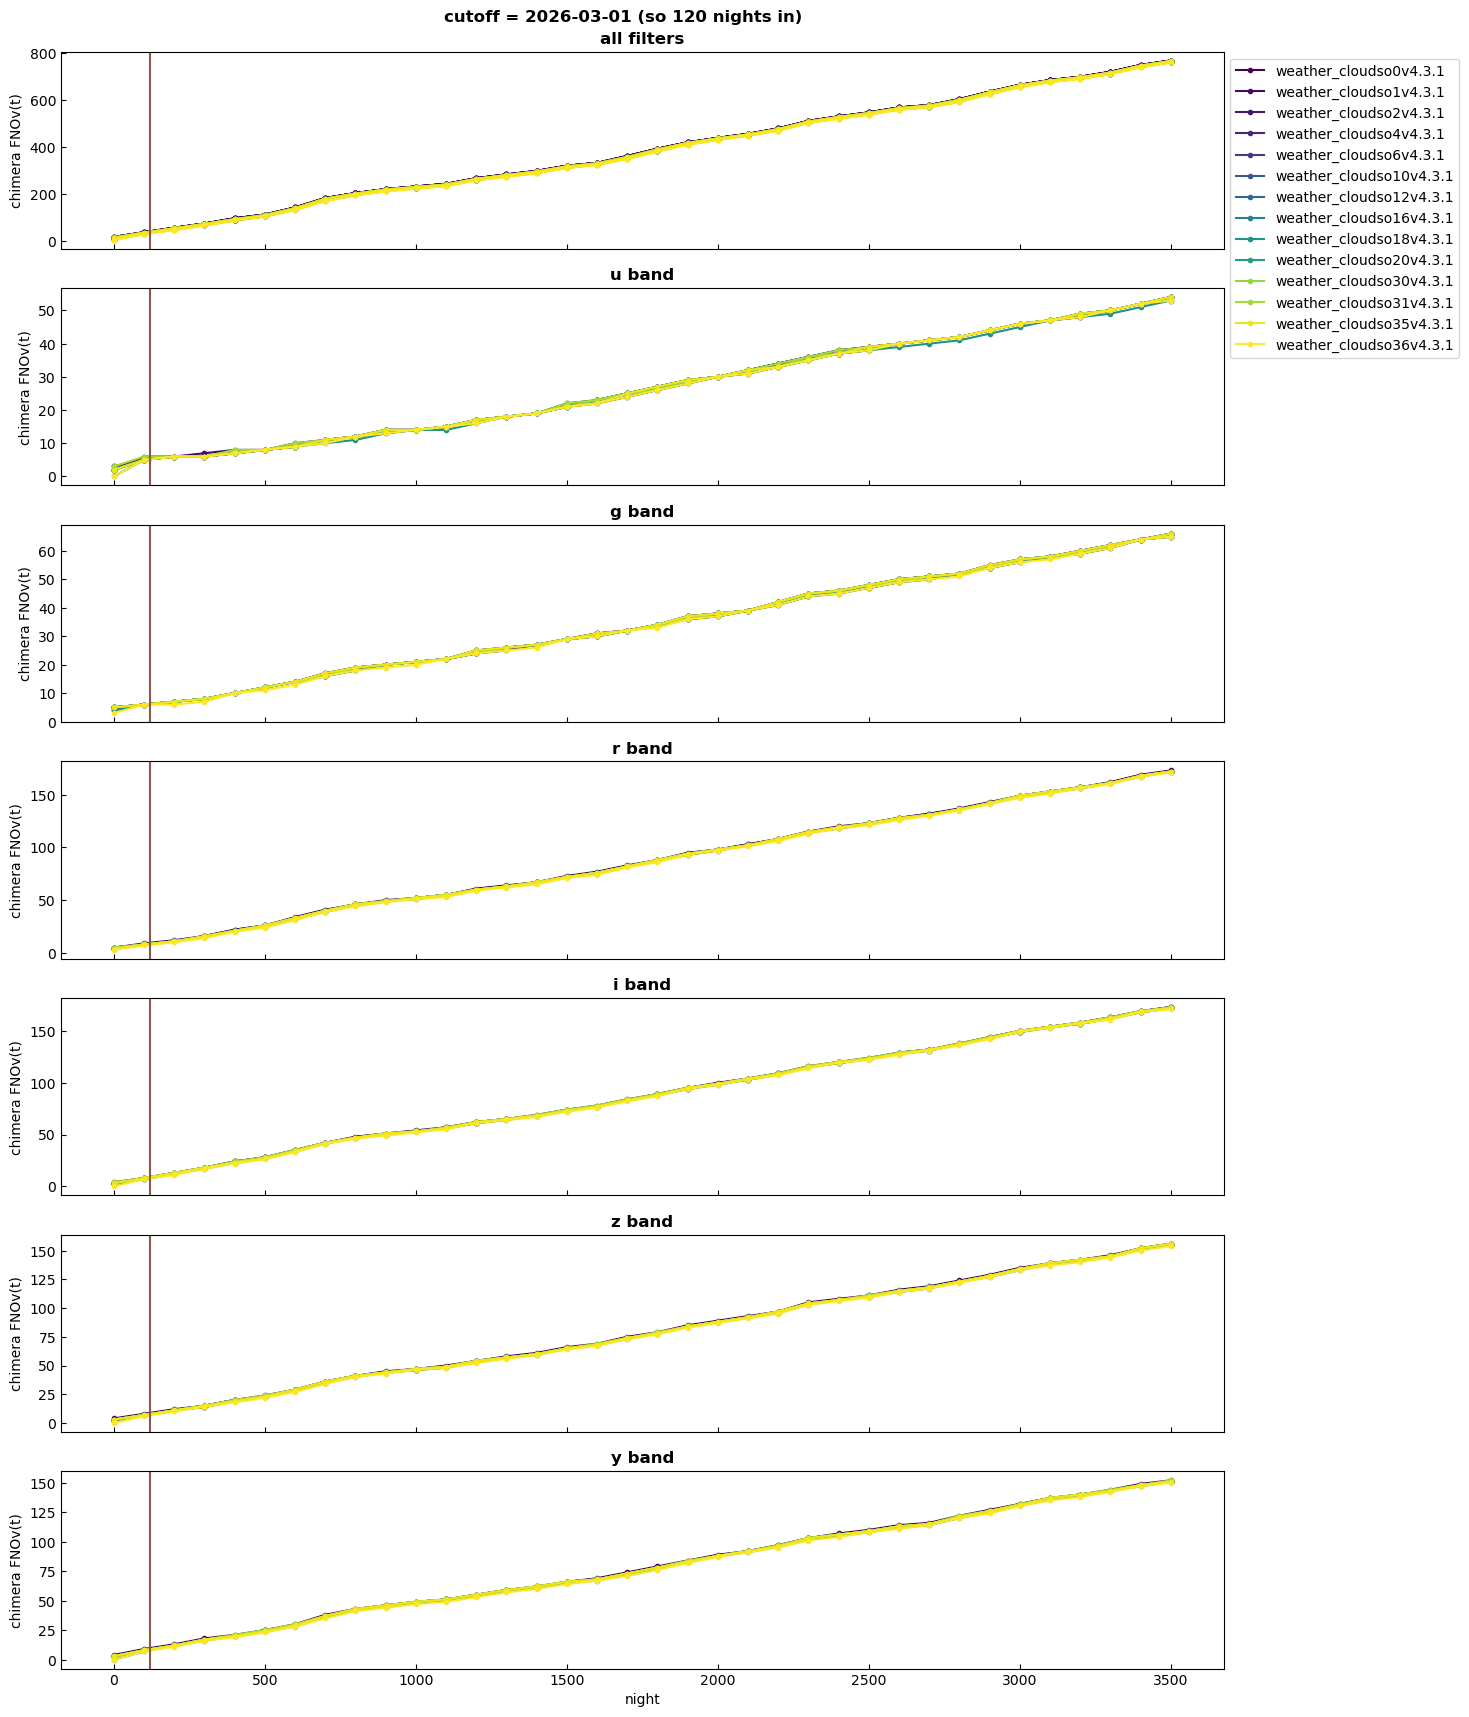

<Figure size 640x480 with 0 Axes>

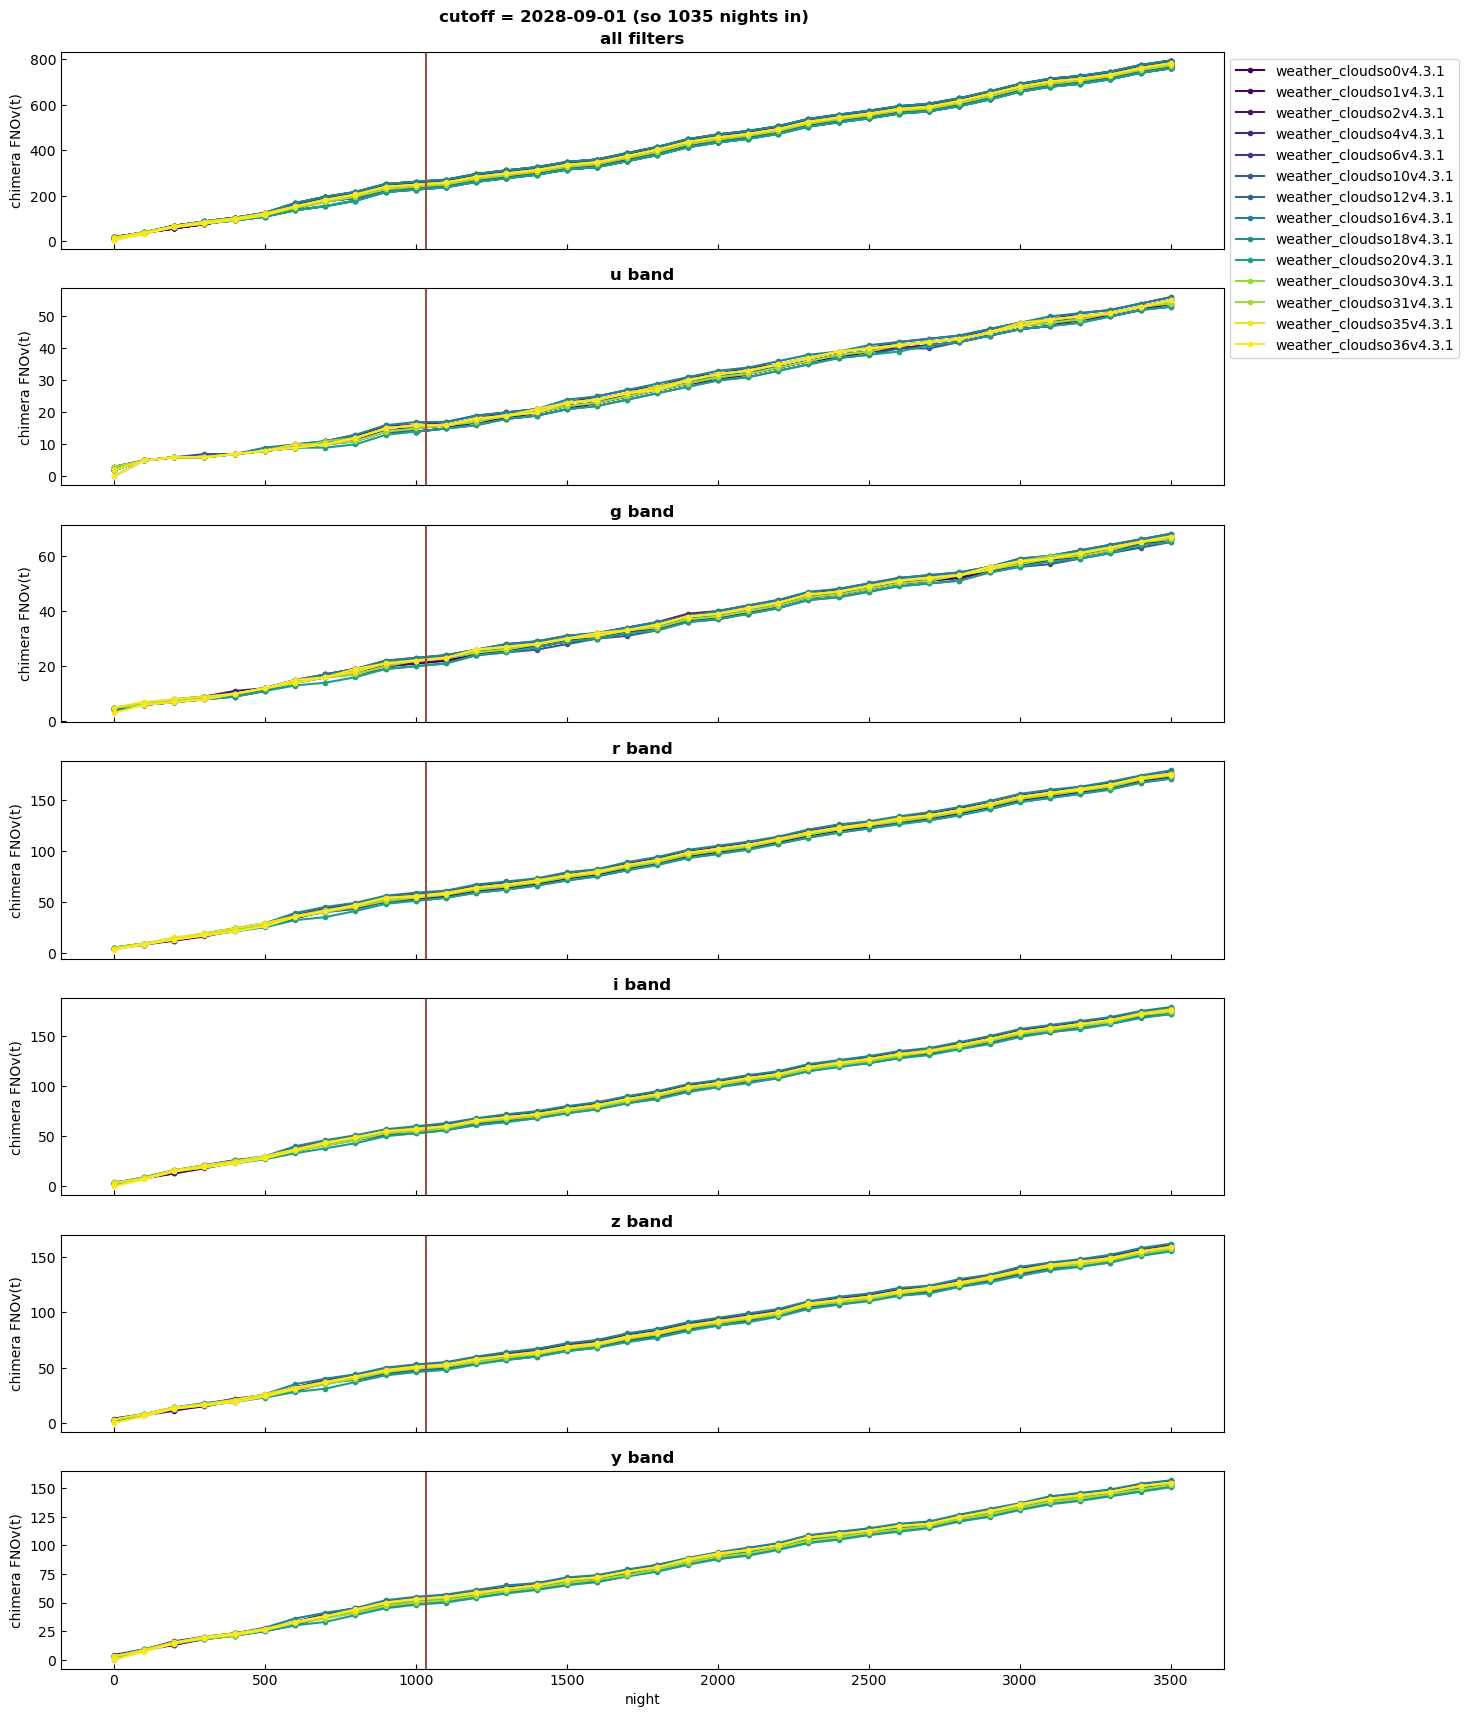

In [11]:
nrows, ncols = 7, 1

for cutoff in chimera_fnovs_time_all:
    plt.clf()
    fig, axes = plt.subplots(nrows, ncols)
    
    for i, filt in enumerate(chimera_fnovs_time_per_filter[cutoff]):
        for j, db in enumerate(list(clouds_tag.keys())):
            if db.__contains__('baseline'):
                color = 'r'
                sym = '+'
            else:
                color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
                sym = '.'

            key = f'chimera_cutoff{cutoff}_{db}'
            axes[0].plot(time_points[:-1], chimera_fnovs_time_all[cutoff][key],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1].plot(time_points[:-1], chimera_fnovs_time_per_filter[cutoff][filt][key],
                            sym+'-', color=color)
    
            if j == 0:
                axes[0].set_title('all filters', fontweight='bold')
                axes[i+1].set_title(f'{filt} band', fontweight='bold')
                
    for k in range(nrows):
        axes[k].tick_params(axis="both", direction="in")
        axes[k].set_ylabel('chimera FNOv(t)')
        ymin, ymax = axes[k].get_ylim()
        axes[k].axvline(cutoff_night[cutoff], ymin, ymax, color='C5', ls='-')
        
    for k in range(nrows-1):
        axes[k].set_xticklabels([])
    
    axes[0].legend(bbox_to_anchor=(1,1))
    axes[-1].set_xlabel('night')

    plt.suptitle(f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)', fontweight='bold', y=0.9)
    fig.set_size_inches(15, nrows*3)
    plt.show()

not very helpful - since we can see by eye what has changed. lets plot the differences between chimera and original sims.

<Figure size 640x480 with 0 Axes>

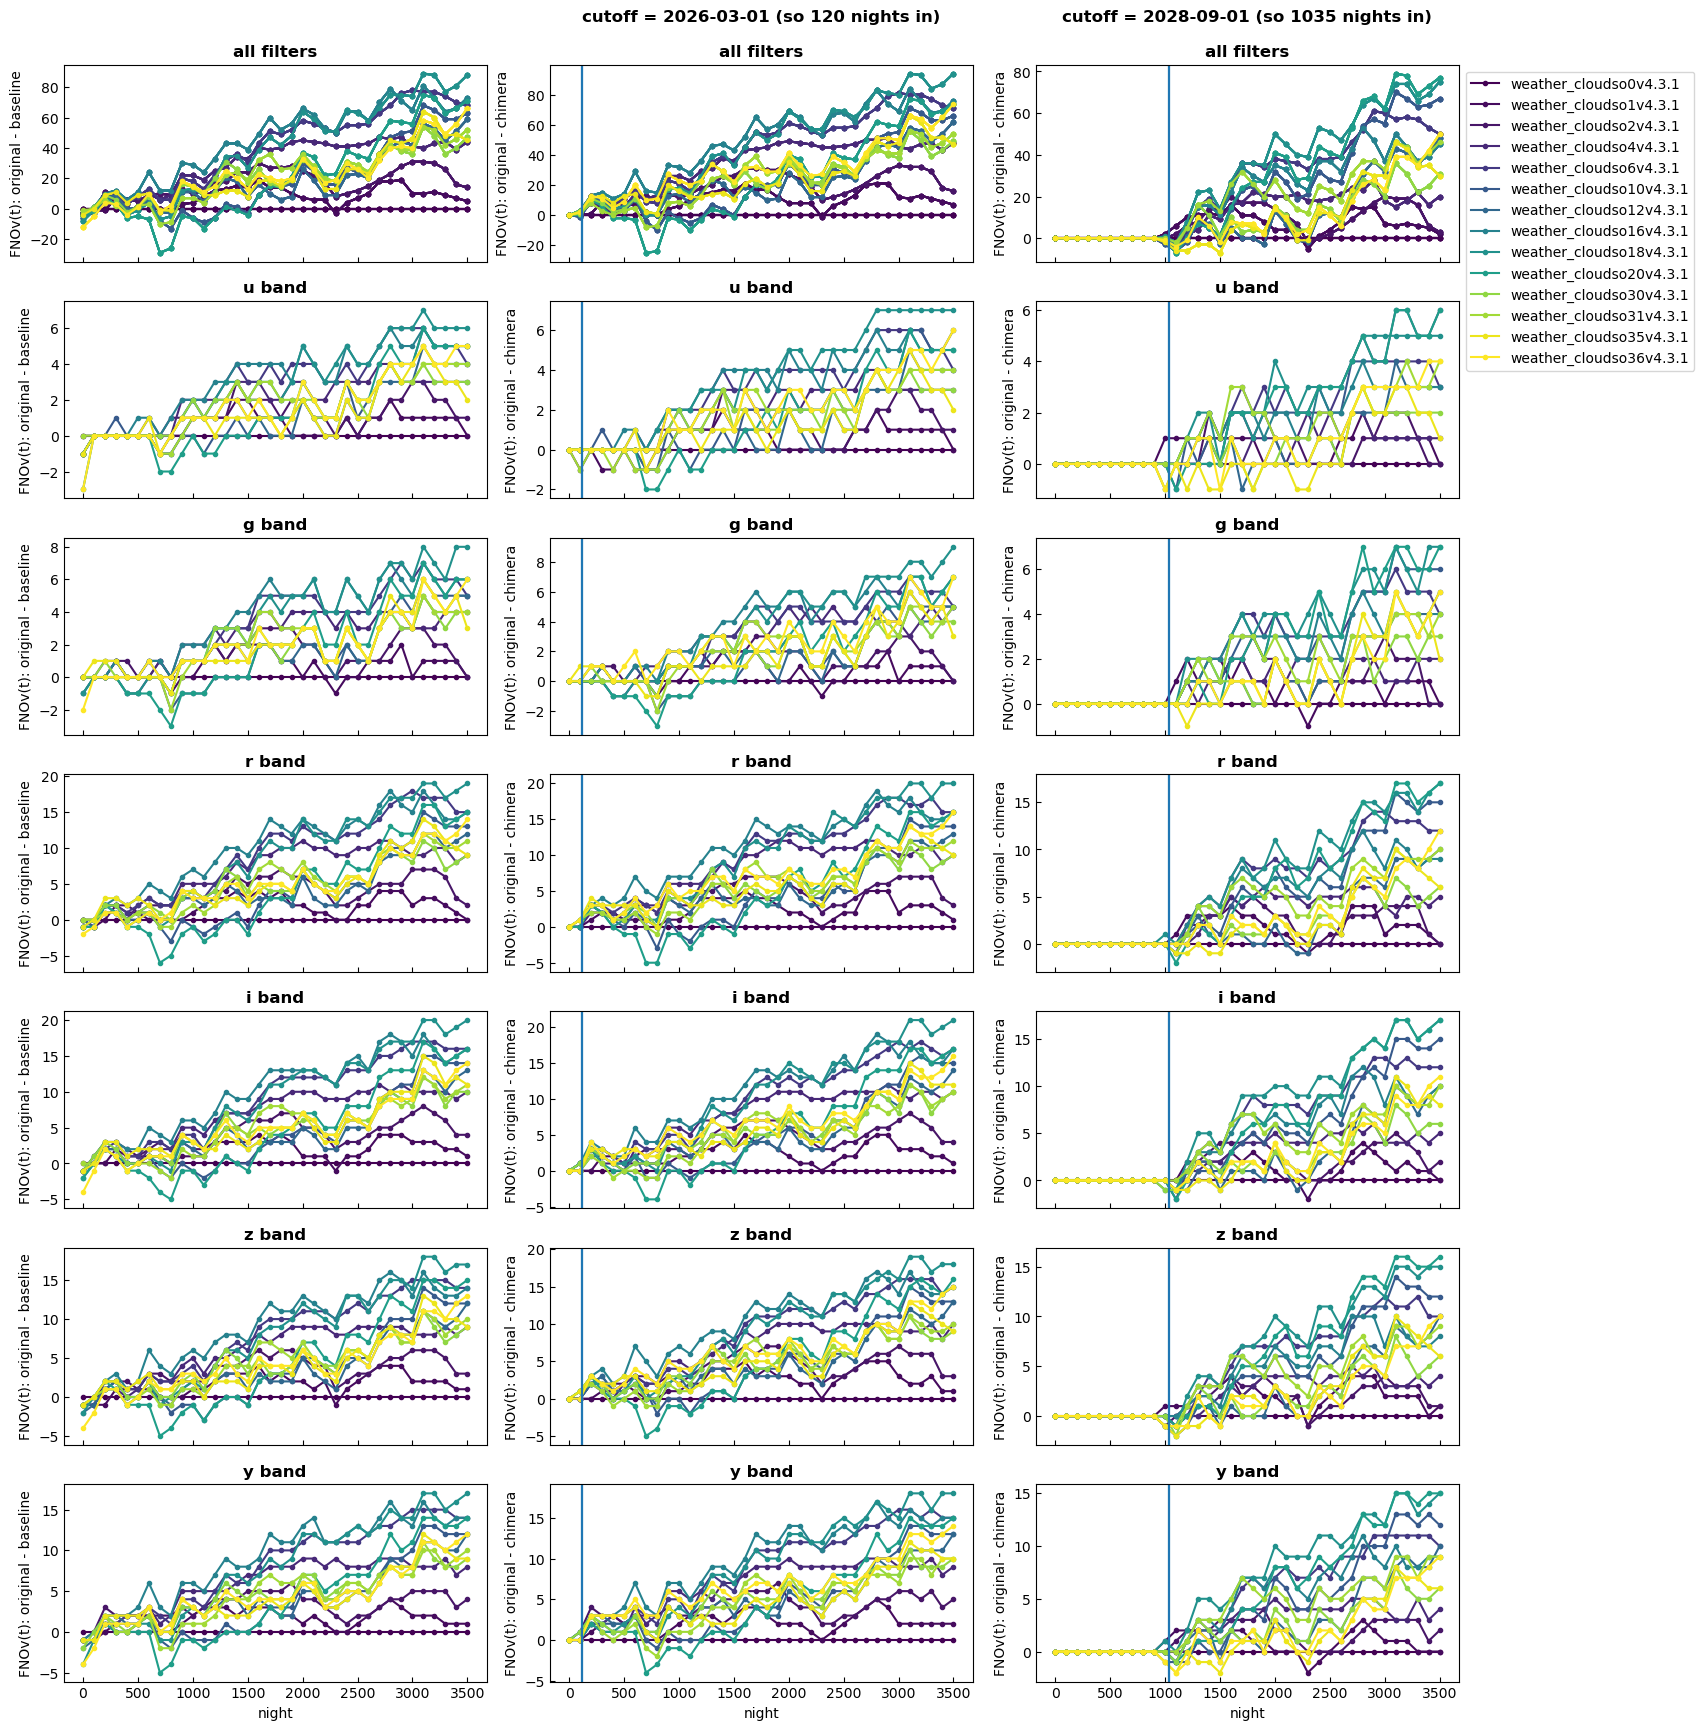

In [12]:
nrows, ncols = 7, 1+len(cutoff_night.keys())


plt.clf()
fig, axes = plt.subplots(nrows, ncols)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
for i, filt in enumerate(fnovs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys())):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
            sym = '.'

        # original vs baseline
        axes[0, 0].plot(time_points[:-1], fnovs_time_all[db] - fnovs_time_all[baseline_tag], sym+'-',
                     label=db if i == 0 else None, color=color)
        axes[i+1, 0].plot(time_points[:-1], fnovs_time_per_filter[filt][db] - fnovs_time_per_filter[filt][baseline_tag],
                       sym+'-', color=color)
        for ci, cutoff in enumerate(chimera_fnovs_time_all):
            # original vs chimera
            key = f'chimera_cutoff{cutoff}_{db}'
            axes[0, ci+1].plot(time_points[:-1], fnovs_time_all[db] - chimera_fnovs_time_all[cutoff][key],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, ci+1].plot(time_points[:-1], fnovs_time_per_filter[filt][db] - chimera_fnovs_time_per_filter[cutoff][filt][key],
                            sym+'-', color=color)
            if j == 0:
                axes[0, ci+1].set_title( f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)\n\nall filters', fontweight='bold')

        if j == 0:
            for col in range(ncols):
                if col == 0:
                    axes[0, col].set_title('all filters', fontweight='bold')
                axes[i+1, col].set_title(f'{filt} band', fontweight='bold')
                
for k in range(nrows):
    for c in range(ncols):
        axes[k, c].tick_params(axis="both", direction="in")

        for ci, cutoff in enumerate(cutoff_night):
            axes[k, ci+1].axvline(cutoff_night[cutoff], ymin, ymax, ls='-')
            axes[k, ci+1].set_ylabel('FNOv(t): original - chimera')
        
    axes[k, 0].set_ylabel('FNOv(t): original - baseline') 
    
for k in range(nrows-1):
    for c in range(ncols):
        axes[k, c].set_xticklabels([])

axes[0, -1].legend(bbox_to_anchor=(1,1))
for c in range(ncols):
    axes[-1, c].set_xlabel('night')

fig.set_size_inches(6*ncols, nrows*3)
plt.show()

ok so the trends are basically the same after the cutoff date - good - with the differences between original and chimera sims more apparent with a cutoff a bit further into the survey.